# Transfer Learning for Sorcero

This is notebook for classifying the health facts dataset according to their claim with the evidences provided. To check for the correctness exceute the cells one by one. Download the dataset from https://drive.google.com/uc?export=download&id=1eTtRs5cUlBP5dXsx-FTAlmXuB6JQi2qj

In [ ]:
!unzip PUBHEALTH.zip
!pip install transformers

Archive:  PUBHEALTH.zip
   creating: PUBHEALTH/
  inflating: PUBHEALTH/train.tsv     
  inflating: PUBHEALTH/dev.tsv       
  inflating: PUBHEALTH/test.tsv      


In [26]:
# Importing Libraries.
import numpy as np
import pandas as pd
import re
import string
import nltk
import tensorflow as tf

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.preprocessing import LabelEncoder
from nltk.stem import WordNetLemmatizer
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, DistilBertConfig, TFDistilBertForSequenceClassification, RobertaTokenizer, RobertaForSequenceClassification

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Reading the Dataset
train_dataset = pd.read_csv('PUBHEALTH/train.tsv', sep='\t', header=0)
valid_dataset = pd.read_csv('PUBHEALTH/dev.tsv', sep='\t', header=0)
test_dataset = pd.read_csv('PUBHEALTH/test.tsv', sep='\t', header=0)

In [3]:
train_dataset.shape, valid_dataset.shape, test_dataset.shape

((9832, 9), (1221, 9), (1235, 10))

In [4]:
# Function to explore the types of data and missing values in the dataset
def data_explore(data):
    print('Number of inputs in data: ' + str(len(data)))
    print('Number of missing value in each column: \n', data.isnull().sum())
    
    data['label'].value_counts().plot(kind='bar', title='Target Distribution')
        
    fc_percent = ((data['fact_checkers'].isnull().sum()) / len(data)) * 100
    sub_percent = float(((data['subjects'].isnull().sum()) / len(data)) * 100)
    
    print('Unique number of Fact Checkers: ', str(data['fact_checkers'].nunique()))
    print('Unique number of Subjects: ', str(data['subjects'].nunique()))

Number of inputs in data: 9832
Number of missing value in each column: 
 claim_id             0
claim                8
date_published    1937
explanation          8
fact_checkers       11
main_text           26
sources             28
label               27
subjects            28
dtype: int64
Unique number of Fact Checkers:  1980
Unique number of Subjects:  5811


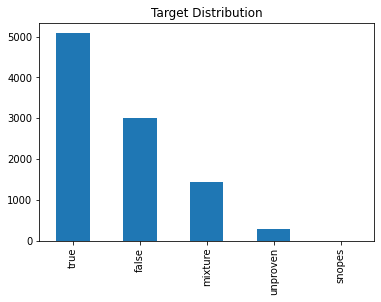

In [5]:
data_explore(train_dataset)

Number of inputs in data: 1221
Number of missing value in each column: 
 claim_id            0
claim               2
date_published    245
explanation         2
fact_checkers       4
main_text           4
sources             5
label               6
subjects            7
dtype: int64
Unique number of Fact Checkers:  438
Unique number of Subjects:  795


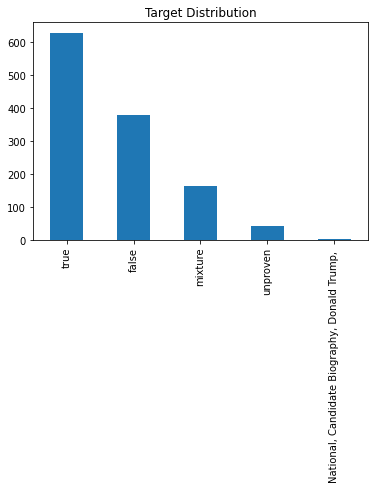

In [6]:
data_explore(valid_dataset)

Number of inputs in data: 1235
Number of missing value in each column: 
 Unnamed: 0          0
claim_id            0
claim               0
date_published    226
explanation         0
fact_checkers       0
main_text           0
sources             0
label               2
subjects            2
dtype: int64
Unique number of Fact Checkers:  447
Unique number of Subjects:  840


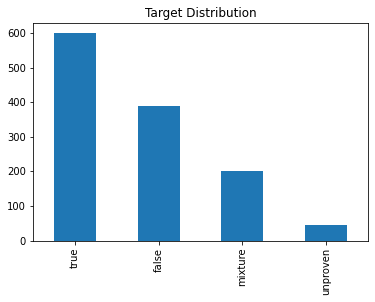

In [7]:
data_explore(test_dataset)

# Data Cleaning

Since the data contains lots of missing values and also contains classes other than the 4 labels. We are removing the rows which does not have claim or evidence and also replacing unknown label with unproven class.

In [8]:
def remove_missing(data):
    data.at[data['label'][data['label'] == 'snopes'].index, 'label'] = 'unproven'
    data.at[data['label'][data['label'] == 'National, Candidate Biography, Donald Trump, '].index, 'label'] = 'false'
    
    data = data[data['claim'].notna()]
    
    data.at[data['label'][data['label'].isna()].index, 'label'] = 'unproven'
    
    print('Number of inputs in data: ' + str(len(data)))
    print('Number of missing value in each column: \n', data.isnull().sum())
    data['label'].value_counts().plot(kind='bar', title='Transformed Target Distribution')
    
    return data

Number of inputs in data: 9824
Number of missing value in each column: 
 claim_id             0
claim                0
date_published    1929
explanation          0
fact_checkers        3
main_text           18
sources             20
label                0
subjects            20
dtype: int64


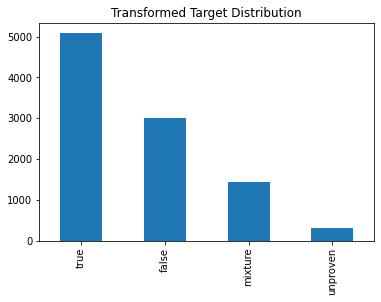

In [9]:
train_dataset = remove_missing(train_dataset)

Number of inputs in data: 1219
Number of missing value in each column: 
 claim_id            0
claim               0
date_published    243
explanation         0
fact_checkers       2
main_text           2
sources             3
label               0
subjects            5
dtype: int64


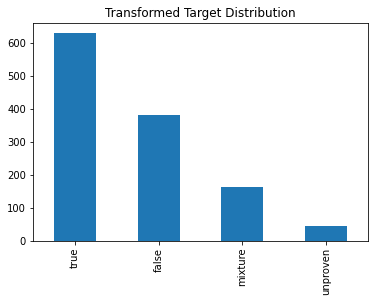

In [10]:
valid_dataset = remove_missing(valid_dataset)

# Preprocessing the Text.

For preprocessing the claim and evidence columns are used. `preprocess` function removes links, numbers, special characters. Also uses NLTK module to remove stopwords and lemmatization was done to these inputs.

In [11]:
# Preprocessing text into input format
def preprocess(text):
    # Removing emojis, emails, numbers
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub('<.*?>+', '', text)
    
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F" 
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF"  
                           "]+", flags = re.UNICODE)
    
    text = regrex_pattern.sub(r'',text)
    text = ''.join([i for i in text if not i.isdigit()])
    
    # Removing Punctuation from the text
    punct = [words for words in text if words not in string.punctuation ]
    words = ''.join(punct)
    
    # Tokenizing the text
    tokens = nltk.word_tokenize(words)
    
    # Removing the stopwords
    stopwords = nltk.corpus.stopwords.words('english')
    for s_words in ['true', 'false', 'mixture', 'unproven']:
        stopwords.append(s_words)
    stop_tokens = [word for word in tokens if word not in stopwords]
    stop_tokens = [word.lower() for word in stop_tokens]
    
    # Appying Lemmatization to the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in stop_tokens])
    
    return lemmatized_output

In [12]:
train_dataset['claim'] = train_dataset['claim'].apply(lambda x: preprocess(x))
train_dataset['explanation'] = train_dataset['explanation'].apply(lambda x: preprocess(x))

In [13]:
valid_dataset['claim'] = valid_dataset['claim'].apply(lambda x: preprocess(x))
valid_dataset['explanation'] = valid_dataset['explanation'].apply(lambda x: preprocess(x))

In [14]:
test_dataset['claim'] = test_dataset['claim'].apply(lambda x: preprocess(x))
test_dataset['explanation'] = test_dataset['explanation'].apply(lambda x: preprocess(x))

In [15]:
proc_train = train_dataset[['claim', 'explanation', 'label']]
proc_valid = valid_dataset[['claim', 'explanation', 'label']]
proc_test = test_dataset[['claim', 'explanation', 'label']]

In [16]:
proc_train.shape, proc_valid.shape, proc_test.shape

((9824, 3), (1219, 3), (1235, 3))

In [17]:
proc_train.head()

,claim,explanation,label
0,the money clinton foundation took foreign gove...,gingrich said clinton foundation took money fo...,false
1,annual mammogram may have more falsepositives,this article report result study nearly woman ...,mixture
2,sbrt offer prostate cancer patient high cancer...,this news release describes fiveyear outcome m...,mixture
3,study vaccine breast ovarian cancer ha potential,while story many thing well overall framing st...,true
4,some appendicitis case may require ’ emergency...,we really ’ understand handful mainstream news...,true


In [79]:
y_train

array([0, 1, 1, ..., 2, 0, 0])

In [18]:
def input_text(claim, evidence):
  return [claim, evidence]

In [19]:
proc_train['text'] = proc_train.apply(lambda x: input_text(x.claim, x.explanation), axis=1)
proc_valid['text'] = proc_valid.apply(lambda x: input_text(x.claim, x.explanation), axis=1)
proc_test['text'] = proc_test.apply(lambda x: input_text(x.claim, x.explanation), axis=1)

In [20]:
proc_test = proc_test[proc_test['label'].notna()]

In [21]:
encoding = LabelEncoder()
y_train = encoding.fit_transform(proc_train['label'])
y_valid = encoding.fit_transform(proc_valid['label'])
y_test = encoding.fit_transform(proc_test['label'])

# DistilBert Model.

For training of text Distilled Bert pretrained model is used. 

In [84]:
config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states = False
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased', max_seq_length=128)
t_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', config=config)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_projector', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_255']
You should probably TRAIN this model on a down-stream task to be able to use 

In [87]:
input_ids_in = tf.keras.layers.Input(shape=(128,), name='input_ids', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(128,), name='attention_mask', dtype='int32') 
embedding_layer = t_model(input_ids_in, attention_mask=input_masks_in)[0]
X = tf.keras.layers.Dense(150, activation='relu')(embedding_layer)
X = tf.keras.layers.Dense(50, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(4, activation='sigmoid')(X)
model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)
model.summary()
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, clipnorm=1.),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.metrics.SparseCategoricalAccuracy()],
        )
 
history=model.fit([encoder_train['input_ids'], encoder_train['attention_mask']], y_train, validation_data=([encoder_valid['input_ids'], encoder_valid['attention_mask']], y_valid), epochs=3, verbose=1)

model.save_weights('./saved_weights1.h5')

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_for_sequence_cla TFSequenceClassifier 66955010    input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dense_25 (Dense)                (None, 150)          450         tf_distil_bert_for_sequenc

# Prediction on test set

Then the encoded test set is used for prediction and performance of the model is measured. 
``` Accuracy - 66% | Precision - 64%%  | Recall - 66%  | F1 Score - 63% ```

In [88]:
logits=model.predict(dict(encoder_test), verbose=1)
prob=tf.nn.softmax(logits, axis=1).numpy()
predictions=np.argmax(prob, axis=1)
#confusion_matrix=tf.math.confusion_matrix([0, 1, 2, 3], predictions, num_classes=4)

39/39 [==============================] - 12s 258ms/step


              precision    recall  f1-score   support

       False       0.53      0.78      0.63       388
     Mixture       0.52      0.18      0.27       201
        True       0.80      0.78      0.79       599
    Unproven       0.00      0.00      0.00        45

    accuracy                           0.66      1233
   macro avg       0.46      0.44      0.42      1233
weighted avg       0.64      0.66      0.63      1233



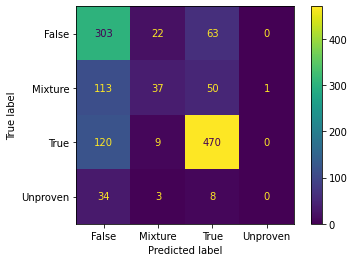

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

report = classification_report(y_test, predictions, target_names=['False', 'Mixture', 'True', 'Unproven'])
print(report)
cm = confusion_matrix(y_true=y_test, y_pred=predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['False', 'Mixture', 'True', 'Unproven'])
disp.plot(values_format='d')

In [90]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base", max_seq_length=128)
t_model = TFAutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=4)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [91]:
encoder_train = tokenizer(list(proc_train['text']), return_tensors="tf", padding=True, truncation=True, max_length=128)
encoder_valid = tokenizer(list(proc_valid['text']), return_tensors="tf", padding=True, truncation=True, max_length=128)
encoder_test = tokenizer(list(proc_test['text']), return_tensors="tf", padding=True, truncation=True, max_length=128)

In [ ]:
input_ids_in = tf.keras.layers.Input(shape=(128,), name='input_ids', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(128,), name='attention_mask', dtype='int32') 
embedding_layer = t_model(input_ids_in, attention_mask=input_masks_in)[0]
X = tf.keras.layers.Dense(100, activation='relu')(embedding_layer)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(4, activation='sigmoid')(X)
model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)
model.summary()
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, clipnorm=1.),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.metrics.SparseCategoricalAccuracy()],
        )
 
history=model.fit([encoder_train['input_ids'], encoder_train['attention_mask']], y_train, validation_data=([encoder_valid['input_ids'], encoder_valid['attention_mask']], y_valid), epochs=3, verbose=1)

model.save_weights('./saved_weights2.h5')

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_roberta_for_sequence_classif TFSequenceClassifier 124648708   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dense_28 (Dense)                (None, 100)          500         tf_roberta_for_sequence_cl

In [ ]:
logits=model.predict(dict(encoder_test), verbose=1)
prob=tf.nn.softmax(logits, axis=1).numpy()
predictions=np.argmax(prob, axis=1)
#confusion_matrix=tf.math.confusion_matrix([0, 1, 2, 3], predictions, num_classes=4)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

report_2 = classification_report(y_test, predictions, target_names=['False', 'Mixture', 'True', 'Unproven'])
print(report_2)
cm = confusion_matrix(y_true=y_test, y_pred=predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['False', 'Mixture', 'True', 'Unproven'])
disp.plot(values_format='d')